In [24]:
import matplotlib.pyplot as plt
import pandas as pd
from pytt.utils import read_pickle
from utils import precision_recall_f1
from sklearn.metrics import roc_curve, precision_recall_curve
import numpy as np
from torch import tensor # TODO: take out when bug fixed

In [25]:
models = ['tfidf', 'cosine', 'description']
base_path = "/Users/jeredmcinerney/Desktop/summary_stats/%s.csv"
dfs = {model:pd.read_csv(base_path % model) for model in models}

In [26]:
dfs['tfidf']

,Unnamed: 0,code_name,code_idx,attention,traceback_attention,label,score,depth,num_report_sentences,patient_id,timepoint_id,reference_sentence_rankings
0,0,custom5,3330,2.855914e+00,2.855914e+00,1,NaN,4,tensor(1000),100134903,1064983,[561]
1,1,174,3124,3.223417e+00,3.223417e+00,1,NaN,3,tensor(1000),100134903,1064983,"[30, 421, 12, 350, 331, 447]"
2,2,custom4,3329,2.849000e+00,2.849000e+00,1,NaN,2,tensor(1000),100134903,1064983,"[408, 407]"
3,3,custom1,3310,2.426118e+00,2.426118e+00,1,NaN,1,tensor(1000),102723010,301023,"[153, 309, 3, 240, 332, 5, 153, 2]"
4,4,346,3228,2.302377e+00,2.302377e+00,1,NaN,2,tensor(1000),102723010,301023,"[4, 49, 6, 0]"
5,0,"('ICD10', 'D352')",1436,6.907995e-01,6.907995e-01,1,NaN,3,tensor(1000),107010572,682054,"[1, 344]"
6,1,"('ICD10', 'I712')",2286,4.091138e+00,4.091138e+00,1,NaN,3,tensor(1000),107010572,682054,"[4, 5]"
7,2,custom2,3321,NaN,NaN,1,NaN,1,tensor(1000),106043972,383599,[45]
8,3,custom5,3330,NaN,NaN,1,NaN,4,tensor(1000),106043972,383599,"[241, 404, 403, 181, 101, 439, 417, 412, 18, 3..."
9,4,340,3224,2.455083e+00,2.455083e+00,1,NaN,2,tensor(1000),106043972,383599,"[0, 176]"


In [27]:
def get_rankings(df):
    return sum([(np.array(eval(row.reference_sentence_rankings))/eval(row.num_report_sentences).item()).tolist() for i,row in df.iterrows()], [])

rankings = {model:get_rankings(df) for model,df in dfs.items()}

tfidf


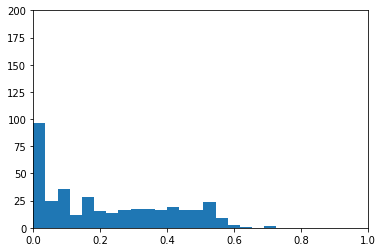

cosine


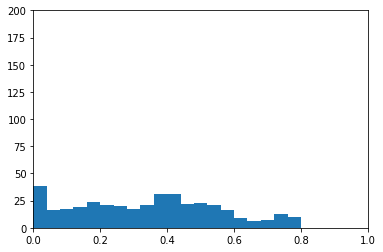

description


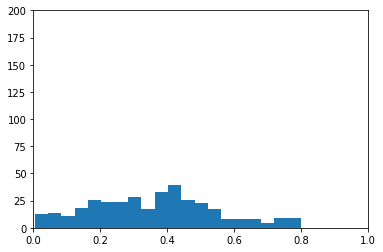

In [32]:
def plot_rankings(rankings):
    plt.hist(rankings, bins=20)
    plt.axis([0, 1, 0, 200])

for model,mrankings in rankings.items():
    print(model)
    plot_rankings(mrankings)
    plt.savefig('/Users/jeredmcinerney/Desktop/plots/rankings_distribution_%s.png' % model)
    plt.show()
    

In [29]:
def get_curve_args(df):
    sentence_rankings, sentence_labels = [], []
    for i,row in df.iterrows():
        num_report_sentences = eval(row.num_report_sentences).item()
        sentence_rankings_temp = list(range(num_report_sentences))
        reference_sentence_rankings = set(eval(row.reference_sentence_rankings))
        sentence_labels_temp = [(i in reference_sentence_rankings) for i in sentence_rankings_temp]
        sentence_rankings += (np.array(sentence_rankings_temp)/num_report_sentences).tolist()
        sentence_labels += sentence_labels_temp
    
    return np.array(sentence_labels, dtype=np.float), -np.array(sentence_rankings, dtype=np.float)

roc_curves = {model:roc_curve(*get_curve_args(df)) for model,df in dfs.items()}
precision_recall_curves = {model:precision_recall_curve(*get_curve_args(df)) for model,df in dfs.items()}

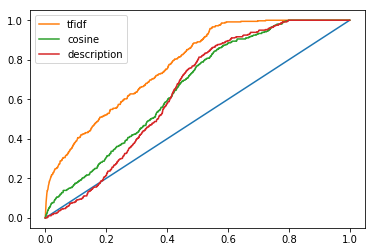

In [30]:
plt.plot([0,1],[0,1])
for model,(fpr, tpr, thresholds) in roc_curves.items():
    line, = plt.plot(fpr, tpr)
    line.set_label(model)
    plt.legend()
#     plt.show()
plt.savefig('/Users/jeredmcinerney/Desktop/plots/roc_curve.png')

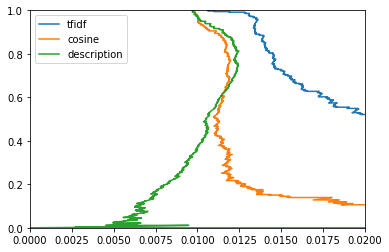

In [31]:
for model,(p, r, thresholds) in precision_recall_curves.items():
    line, = plt.plot(p, r)
    line.set_label(model)
    plt.legend()
#     plt.show()
plt.axis([0,.02,0,1])
plt.savefig('/Users/jeredmcinerney/Desktop/plots/precision_recall_curve.png')

In [ ]:
tfidf_df = dfs['tfidf']
tfidf_df.timepoint_id[tfidf_df.reference_sentence_rankings]